In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
# Unggah dataset
uploaded = files.upload()

Saving dataset_tempat_wisata_malang.csv to dataset_tempat_wisata_malang.csv


In [ ]:
# Load dataset
data = pd.read_csv("dataset_tempat_wisata_malang.csv", sep=";")

# Preprocessing
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    return stopword_remover.remove(text.lower())

# Combine features and preprocess
data['combined_features'] = data['name'] + " " + data['category'] + " " + data['description']
data['combined_features'] = data['combined_features'].apply(preprocess_text)

# Vectorize using TF-IDF
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(data['combined_features'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
# Prepare data for training
pairs = []
scores = []
for i in range(len(cosine_sim)):
    for j in range(len(cosine_sim)):
        if i != j:  # Avoid self-comparison
            pairs.append((tfidf_matrix[i].toarray().flatten(), tfidf_matrix[j].toarray().flatten()))
            scores.append(cosine_sim[i, j])

# Convert to numpy arrays
pairs_array = [np.concatenate(pair) for pair in pairs]
scores_array = np.array(scores)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(pairs_array, scores_array, test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Build TensorFlow model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0021 - mae: 0.0287 - val_loss: 0.0012 - val_mae: 0.0213
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 9.7273e-04 - mae: 0.0198 - val_loss: 0.0010 - val_mae: 0.0197
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 6.9646e-04 - mae: 0.0168 - val_loss: 8.8690e-04 - val_mae: 0.0194
Epoch 4/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5.4703e-04 - mae: 0.0153 - val_loss: 8.5114e-04 - val_mae: 0.0184
Epoch 5/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 4.5389e-04 - mae: 0.0142 - val_loss: 8.0720e-04 - val_mae: 0.0177
Epoch 6/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.8505e-04 - mae: 0.0131 - val_loss: 7.6616e-04 - val_mae: 0.0177
Epoch 7/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.2558e-04 - mae: 0.0124 - val_loss: 7.5846e-04 - val_mae: 0.0176
Epoch 8/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.8133e-04 - mae: 0.0117 - val_loss: 7.6499e-04 - val_mae: 0.0176
Epo

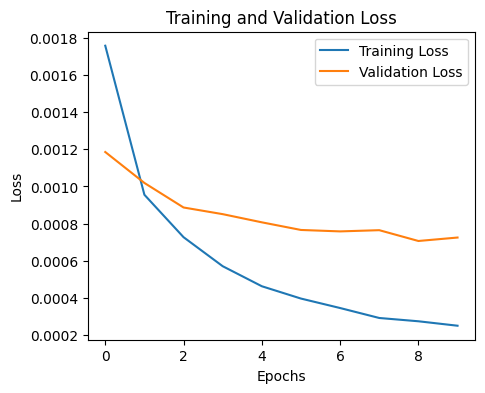

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Example usage
def predict_relevance(input_features):
    input_vector = tfidf.transform([preprocess_text(input_features)]).toarray().flatten()
    recommendations = []

    for idx in range(len(data)):
        place_vector = tfidf_matrix[idx].toarray().flatten()
        combined_vector = np.concatenate((input_vector, place_vector))
        combined_vector = tf.convert_to_tensor([combined_vector], dtype=tf.float32)

        # Predict the score
        predicted_score = model.predict(combined_vector)[0][0]
        recommendations.append((data.iloc[idx]['name'], data.iloc[idx]['description'], predicted_score))

    # Sort by predicted score in descending order
    recommendations = sorted(recommendations, key=lambda x: x[2], reverse=True)
    return recommendations


In [ ]:
# Example prediction
example_input = "Museum Zoologi Frater Vianney"
predicted_scores = predict_relevance(example_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━

In [ ]:
# Display recommendations
print("Rekomendasi tempat wisata serupa:")
for name, description, score in predicted_scores[:10]:  # Display top 10
    print(f"Nama: {name}, Deskripsi: {description}, Predicted Score: {score}")

Rekomendasi tempat wisata serupa:
Nama: Museum Zoologi Frater Vianney, Deskripsi: Museum yang sangat direkomendasikan untuk dikunjungi di Malang. Tidak ada biaya masuk, jadi Anda dapat mengunjunginya dengan bebas. Pemandu wisata sangat membantu dan dapat diandalkan dalam menjelaskan semua tentang koleksi museum., Predicted Score: 0.2723393738269806
Nama: Panji Museum, Deskripsi: Museum ini didedikasikan untuk menjelaskan legenda dan cerita rakyat tentang Panji, yang sangat terkenal di wilayah Malang, Predicted Score: 0.24430102109909058
Nama: Museum Satwa, Deskripsi: Mereka membuat museum ini tepat di samping pintu masuk kebun binatang. Museum ini sangat besar dan memiliki banyak model binatang. Cocok untuk dikunjungi bersama anak-anak untuk mendapatkan informasi., Predicted Score: 0.22012773156166077
Nama: Museum Motor Klasik, Deskripsi: Sebuah museum yang didirikan oleh SMK National Media Center (NMC) pada Maret 2022 dan menjadi tempat yang sangat menarik bagi pecinta otomotif, Predi

In [ ]:
# Save the model
model.save('recommender_model.h5')

In [ ]:
# Asumsikan model Anda adalah model yang telah dilatih
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open('model_malang.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpg0fubl5i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2880), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134675415947344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134675415946288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134675415950160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134675415948752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134675415944528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134675415951216: TensorSpec(shape=(), dtype=tf.resource, name=None)
